In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns=100

plt.rcParams['figure.figsize'] = (9.0, 9.0)
plt.rc('text', usetex=False)

%load_ext autoreload
%autoreload 2

# Overview

On November 8, the consensus among polls was that Sec. Hillary Clinton would win the presidency of the United States, with a final vote margin of 3% or 4%. She was projected to win by comfortable majorities in Michigan and Wisconsin, and to win by a smaller margin in Pennsylvania, which were dubbed her "firewall" against a Donald Trump win.

Instead Clinton won the popular vote by a much smaller margin, between 0.2% to 1.5% (these votes are still being counted), and she lost Michigan, Wisconsin, and Pennsylvania by close margins.

This left a major question -- how did almost all polls systematically miss in their predictions of the election day outcome? This demo is a simplified illustration of one of the major story lines in this polling miss: a systematic mis-prediction of the behavior of white working class voters.

# A Primer on the Presidential Election Process (Plus FAQ)

## The Electoral College

If you didn't grow up in the United States, here is a quick explanation of how the presidential election process works.

On election day, individual votes are counted within voting regions that mostly correspond to states. There are 51 voting regions in the U.S.: 50 states, plus the capital city Washington D.C., and each of these regions has a certain number of **electoral votes**. These votes are assigned as follows: each region is given 3 votes automatically, with additional votes going to each region roughly in proportion to their populations. You can dive deeper into the technicalities [here](https://en.wikipedia.org/wiki/Electoral_College_%28United_States%29). With some exceptions, the candidate receiving the most votes within each region is awarded all of that region's electoral votes. In total, there are 538 electoral votes, so if a candidate receives at least 270 electoral votes, they win the election. (The following image is from the Wikipedia article.)

![Image of 2016 EC](https://upload.wikimedia.org/wikipedia/commons/e/ec/ElectoralCollege2016.svg)

Because of the indirectness of the electoral college, it is possible, as in this election, that the candidate winning the largest number of overall votes (called the "popular vote") does not win the most electoral votes. Thus, to predict the outcome of the presidential election, we need to predict how many votes each candidate will get in each state, rather than predicting total votes. In the rest of this demo, we will consider the problem of estimating the vote share for a particular candidate -- to predict the election, we would apply this method to each state and Washington, DC separately.

## Q: Do we even know what happened?

In some ways, yes. The electoral majority winner is set. There are not enough votes left to be counted in states that matter for this outcome of the election to change.

However, votes are still being counted in many places. In particular, Michigan is still too close to call. Votes from highly populous states like California and New York are still being counted, and because they lean heavily democratic, Hillary Clinton's popular vote lead is still rising. As of Nov 15, this lead has exceeded 1 million votes.

Because votes are still being counted, the total turnout picture is still unclear. As of Nov 15, there were more votes cast in this election than any other besides 2008.

## Q: How can we find out who voted in which way?

The secret ballot is a foundation of American democracy, so there is no way to know for sure who voted for whom. However, we can get clues.

A popular, but non-scientific tool, is exit polling, where people volunteer to give information about their vote and their rationale. These are not useful for making precise estimates, but that can be interesting for understanding what sorts of opinions can be held by the same person simultaneously.

Other non-scientific tools are organizing apps, e.g., Brigade.

The most scientific method is **ecological inference**. This works by looking at the exact demographics of the people who voted, and the aggregate vote totals at the precinct level, which are available. By looking at many precincts together, we can try to reconstruct voting patterns based on certain demographic groups. Ecological inference is not certain, but it is the most scientific means we have (in that we can actually put bounds on the error that is made).

# How Election Polling Works

## Disclaimer

All numbers past this point are **made up** and intended only for the purpose of demonstration. The intention is to match qualitatively what we saw among different groups this election, but they should not be given any weight in terms of understanding how people in the country *actually* voted.

## Mechanics of an Election

Model: there is a group of people; these people have different preferences and will make different decisions about whether to vote. On election day, we observed the sum of the preferences of people who decide to vote.

<!--[[ Demo using red and blue squares in one bar, black and white squares underneath. Arrow showing red and blue squares passing through to bottom row of red, blue, and blanks. Average at the end. ]]-->


## Population Setup

If we want to understand this system, we need to understand these two unknown quantities.

When we try to predict how people will vote, there are two unknown quantities:

 * The **preferences** of the people in the population who are registered to vote,
<!--[[ Preference stripe ]]-->
 * The proportion of people who will turn out to vote, or **turnout** for short.
<!--[[ Turnout stripe ]]-->

We will think of these as unknown lists of numbers of 0's and 1's. Each list contains $N$ elements, each corresponding to a person in the population.

We will write citizen preferences as a list $c$ (for "candidate"),  where $c_i = 1$ if person $i$ supports Hillary Clinton and $c_i = 0$ if they support Donald Trump. For simplicity in this exercise, we will assume that these were the only two choices.

We will write citizens' decisions to vote as a list $t$ (for "turnout"), where $t_i = 1$ if person $i$ will turn out to vote, and $t_i = 0$ if they will not.

The following code generates a population of one million people where different subgroups of the population have different average candidate preferences and average likelihood to turn out.

In [3]:
# Total population size
N = 1e6

# Names of demographic groups
demos = ['min_hi', 'min_low', 'white_hi', 'white_low']

# Proportion of the population made up by each demographic group
size_props = pd.Series({'min_hi': 0.13, 'min_low': 0.13, 'white_hi': 0.24, 'white_low': 0.50})

# Candidate preference probabilities in each demographic group
cand_probs = pd.Series({'min_hi': 0.8, 'min_low': 0.8, 'white_hi': 0.45, 'white_low': 0.3})

# Two possible turnout probabilities for each demographic group
# (Made up) estimated probabilities from historical turnout
turn_probs1 = pd.Series({'min_hi' : 0.6, 'min_low': 0.55, 'white_hi': 0.45, 'white_low': 0.3})
# (Made up) actual turnout probabilities
turn_probs2 = pd.Series({'min_hi' : 0.6, 'min_low': 0.55, 'white_hi': 0.45, 'white_low': 0.4})

# Generate candidate preference, and two turnout scenarios for each demographic
pop_comp = {}
for k in demos:
    pop_comp[k] = {}
    pop_comp[k]['c'] = np.random.binomial(1, cand_probs.loc[k], size=int(N*size_props.loc[k]))
    pop_comp[k]['t'] = np.random.binomial(1, turn_probs1.loc[k], size=int(N*size_props.loc[k]))
    pop_comp[k]['t2'] = np.random.binomial(1, turn_probs2.loc[k], size=int(N*size_props.loc[k]))
    
# Build full population from demographic groups
# Demographic label for each "person" in the population.
sub_label = np.repeat(demos, (size_props * N).astype(int))

# Candidate preference list.
clist = np.concatenate([pop_comp[k]['c'] for k in demos])

# Turnout under "historical turnout" scenario
tlist1 = np.concatenate([pop_comp[k]['t'] for k in demos])
# Turnout under "observed" scenario
tlist2 = np.concatenate([pop_comp[k]['t2'] for k in demos])

# Total votes for candidate under "historical turnout" scenario
wlist1 = np.concatenate([pop_comp[k]['c']*pop_comp[k]['t'] for k in demos])
# Total vaotes for candidate under "observed" scenario
wlist2 = np.concatenate([pop_comp[k]['c']*pop_comp[k]['t2'] for k in demos])

From this, we can compute the vote share for the candidate of interest under the two turnout scenarios. Candidate preferences under both of these scenarios are the same, but turnout is different. If these ideas aren't clear yet, they will be once you've read through the rest of the notebook.

In [4]:
print "Vote share under historical model of turnout: %s" % (float(sum(wlist1))/sum(tlist1))
print "Vote share under actual turnout: %s" % (float(sum(wlist2))/sum(tlist2))

Vote share under historical model of turnout: 0.524431374667
Vote share under actual turnout: 0.499633947791


## Estimating Preferences with Random Sampling (Compulsory Voting Case)

### Estimation target: population candidate preference

Consider how polling would work if there were **compulsory voting** among all registered voters. The problem of predicting the election result would be equivalent to estimating candidate preference among all registered voters.

We will write the vote share for a particular candidate using the letter $w$. **In a world with compulsory voting**, Clinton's vote share would be equal to the mean voter preferance for her:

$$
\mu_c = \frac{1}{N} \sum_{i=1}^N c_i,
$$

or a straightforward average of the candidate preference list.

### Estimation

A simple way to estimate this is to take a random sample of $n$ people from the population, and take a sample average. As discussed in class, we can represent such a sample as a collection of random variables $C_1, \cdots, C_n$, whose joint distribution is determined by the sampling scheme we decide to use.

We can write each sample member $C_j$, in terms of a set of **selection indicators** $I_{ij}$, defined as

$$
I_{ij} = \left\{ \begin{array}[l] 1 \textrm{ if person }i\textrm{ is selected to be the }j\textrm{th sample member}\\
                               0 \textrm{ otherwise.} \end{array}\right.
$$

Under this representation,

$$
C_j = \sum_{i=1}^N I_{ij} c_i,
$$

where for all of the indicators $I_{1j}, I_{2j}, \cdots, I{Nj}$, only one of $I_{ij}$ is not zero, and $P(I_{ij} = 1) = \frac{1}{N}$ for each $I_{ij}$. Thus, the expectation of each $C_j$ is the population mean candidate preference:

$$
E(C_j) = \sum_{i=1}^N E(I_{ij}) c_i = \frac{1}{N} \sum_{i=1}^N c_i = \mu_c.
$$

Thus, a reasonable estimate of $\mu_c$, is the sample average of our sample $C_1, \cdots, C_n$, which we will call $\hat c$:

$$
\hat c = \frac{1}{n}\sum_{j=1}^n C_j.
$$

Note that, in expectation, $\hat c$ is yields the true population preference, $\mu_c$

$$
E(\hat c) = \frac{1}{n} \sum_{j=1}^n E(C_j) = \frac{1}{n} \sum_{j=1}^n \mu_c = \mu_c.
$$

The variance of $\hat c$ has the form

$$
Var(\hat c) = \frac{1}{n^2} \sum_{j=1}^n Var(C_j) + 2\sum_{j=1}^n\sum_{\{k: k < j\}} Cov(C_j, C_k).
$$

The $Cov$ terms in the above expression quantify how different elements of the sample tend to deviate simultaneously from their mean (we'll discuss this later when we talk about correlation). These terms are zero if each sample member $C_j$ in the sample is independent of all other memebers (for example, if sampling were done *with replacement*). These tersm are negative if the sample members $C_j$ are negatively correlated -- that is, if seeing a large value of $C_j$ in the sample would imply that the other samples would tend to be smaller (for example, if sampling were done *without replacement*). Usually polls are done *without replacement*, so we will use the variance from the independent case as an **upper bound** for the variance of the standard polling estimator.

Writing the standard deviation of the population candidate preferences, $SD(c)$ as $\sigma_c$:

$$
Var(\hat c) \leq \frac{1}{n^2} \sum_{j=1}^n Var(C_j) = \frac{1}{n^2} \sum_{j=1}^n \sigma^2_c = \frac{\sigma^2_c}{n}.
$$

Thus, we can conservatively approximate the standard deviation of $\hat c$, often called the **standard error** as

$$
SD(\hat c) \approx \frac{\sigma_C}{\sqrt{n}}.
$$

# Demo of compulsory voting case

Below, we simulate 1000 polls taken from our fixed population of voters. In each poll, 1000 people are sampled without replacement from the population. Under the compulsory voting scheme, all voters will vote according to their preference, we we only need to record candidate preferences for each sampled individual.

We examine the performance of the sample mean estimate $\hat c$ for estimating $\mu_c$ and compare it to theory.

In [5]:
# Number of simulations to run.
M = 1000
# Sample size.
n = 1000.
compuls_v = np.zeros(M)
for i in np.arange(M):
    # Draw selection indicators.
    selection = np.random.choice(np.arange(clist.size), size=int(n), replace=True)
    # Select votes from candidate preference.
    votes = clist[selection]
    # Compute vote share.
    compuls_v[i] = np.mean(votes)

The histogram below shows a vertical blue line at the population mean preference $\mu_c$, and vertical red lines $\mu_c \pm 2 \frac{\sigma_c}{\sqrt n}$.

By Chebyshev's inequality, we would expect no more than $25\%$ of realized values of $\hat c$ to fall outside of this range. By the tighter Central Limit Theorem, we would expect approximately $5\%$ of realized values of $\hat c$ to fall outside of this range.

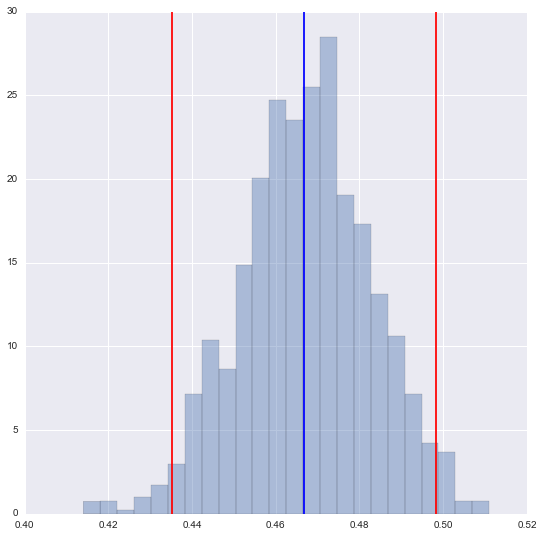

Percentage of samples outside of range: 0.042000


In [22]:
sns.distplot(compuls_v, kde=False, norm_hist=True)
plt.axvline(np.mean(clist))

upper = np.mean(clist) + 2*np.std(clist)/np.sqrt(n)
lower = np.mean(clist) - 2*np.std(clist)/np.sqrt(n)
plt.axvline(upper, c='red')
plt.axvline(lower, c='red')
plt.show()

print "Percentage of samples outside of range: %f"%(np.mean((compuls_v > upper) | (compuls_v < lower)))

The lenght between the red lines is about 6 percentage points across, which is a pretty standard margin of error (3 points) for a public opinion poll.

## Preferences Plus Turnout (Non-Compulsory Voting Case)


### Estimation target: population candidate vote share

For many reasons, real elections are more complicated. In this section, we consider the complication that voting is not compulsory, so we need to estimate not only which individuals support each candidate, but also which individuals will turn out ot vote. This is where the population list $t$ comes in.

In this more complicated setting will write vote totals using the letter $w$. In this notation, the total number of voters is

$$
\mu_w^{tot} = \sum_{i=1}^n t_i,
$$

and the total number of votes for Clinton is

$$
\mu_w = \sum_{i=1}^N t_i c_i.
$$


We will write vote shares, or ratio of total voters supporting a particular candidate, using the letter $v$. In our notation, the population vote share for Clinton is

\begin{align}
\mu_v &= \frac{\mu_w}{\mu_w^{tot}}\\
  &= \frac{\sum_{i=1}^N t_i c_i}{\sum_{i=1}^N t_i}\\
  %&= \sum_{i=1}^N \frac{t_i}{\sum_{i=1}^N t_i} c_i\\
  %&= p_t^{Clinton} \cdot 1 + (1-p_t^{Clinton}) \cdot 0
\end{align}

<!-- In this representation, the final vote share for a candidate is the **turnout-weighted average** of overall candidate preferences. -->

Note that this reduces to $\mu_c$ if every registered voter turns out, or $t_i = 1$ for each $i$ in $1, \cdots, N$.

### Estimation

Similarly to what we did for estimating population candidate preference, we can estimate population vote share by taking a sample of people from the population, observing their candidate preference and turnout status, and computing a sample vote share.

As in the previous example, let $C_1, \cdots, C_n$ be the candidate preferences of $n$ people randomly sampled from the population, and let $T_1, \cdots, T_n$ be the turnout status of those same $n$ randomly sampled people. We can compute

$$\hat v = \frac{\sum_{j=1}^n T_j C_j}{\sum_{j=1}^n T_j},$$

and use this as an estimate of the population vote share $\mu_v$.

Computing the expectation and variance of $\hat v$ is tricky and beyond what we've discussed in the course. This is because it involves the quotient of two sums that are related to each other. Suffice it to say that the behavior of this estimator is well understood, and that its expectation is close, but not exactly equal to, $\mu_v$.

For now we'll use simulation to understand how this estimate works.

### Demo of Non-Compulsory Voting Case

Below we simulate 1000 polls taken from our fixed population of voters. Each poll randomly samples 1000 people from the population without replacement, measures their candidate preference and turnout status, and computes $\hat v$ from that sample.

In [7]:
M = 1000
samp_turnout_v = np.zeros(M)
for i in np.arange(M):
    selection = np.random.choice(np.arange(wlist2.size), size=int(n), replace=True)
    turnout = tlist2[selection]
    votes = wlist2[selection]
    samp_turnout_v[i] = float(sum(votes)) / sum(turnout)       

Below we plot the distribution of $\hat v$ across repeated samples. The blue line is the population vote share for the candidate, $\mu_v$ under the true turnout scheme (not the one estimated from historical data).

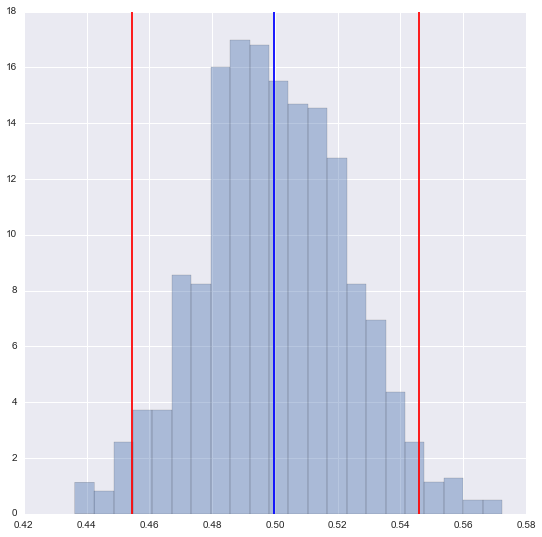

In [8]:
sns.distplot(samp_turnout_v, kde=False, norm_hist=True)
plt.axvline(float(np.sum(wlist2)) / np.sum(tlist2))
plt.axvline(np.percentile(samp_turnout_v, 2.5), c='red')
plt.axvline(np.percentile(samp_turnout_v, 97.5), c='red')

Note that once we include turnout, we have a much noisier estimate because we are not sure how many people will turn out to vote -- the interval containing 95% of our realizations of $\hat v$ is about 9 percentage points across -- and this is under the best case scenario where, among sampled people, we are able to get a good measurement of their decision to vote.

### Problems with Measuring Turnout

In reality, **self-reported vote likelihood is a poor measure of actual turnout**, so estimating turnout is very difficult and this sort of approach is not directly feasible.

There are several reasons for this difficulty:

 * People may lie about their likelihood to vote because they fear being judged by the pollster.
 * People are often willing to commit to responsibilities in the future without considering the cost of fulfilling that responsibility.
 * The people who answer political polls are more likely to be civically engaged and will not be representative of the population turnout picture.
 * More recently, with new voting regulations, many people who intend to vote are not allowed to.
 
This is a hurdle that could make most polling estimates dead on arrival because vote share requires that we be able to estimate each person's candidate preference and turnout status simultaneously. To deal with this issue, pollsters use a fundamental survey samplign technique called stratification.

## Stratification

### The Importance of Correlation

We can circumvent difficulties of needing to measure each person's simultaneous candidate preference and turnout status if **vote turnout and candidate preference are unrelated**.

By definition, if $c$ and $t$ are **uncorrelated**, by using the computational form of the covariance we know

\begin{align}
\frac{1}{N} \sum_{i=1}^N c_i t_i - \mu_c \mu_t = 0.
\end{align}

If this is true, then

\begin{align}
\frac{1}{N} \sum_{i=1}^N c_i t_i &= \mu_c \mu_t\\\\
\frac{\frac{1}{N} \sum_{i=1}^N c_i t_i}{\mu_t} &= \mu_c\\\\
\frac{\frac{1}{N} \sum_{i=1}^N c_i t_i}{\frac{1}{N} \sum_{i=1}^N t_i} &= \mu_c\\\\
\mu_v = \mu_c
\end{align}

This is to say that if $c$ and $t$ are uncorrelated, then the vote share for a candidate is equal to the population preference for that candidate, so we can get away with estimating $\mu_c$ in place of estimating $\mu_v$.

Of course, this is not usually the case in a voting population. Most of the time, probability of turning out varies among different groups of people and aligns with political preferences. However, if we are able to identify groups of people who are relatively homogeneous *within their group*, then this assumption becomes more plausible within that group. We call these groups that we divide the population into **strata** (plural of **stratum**).

### Running Example: Race/Income Strata

**Disclaimer**: *This part of the example paints with very broad strokes a number of very complex political and social issues. It is meant to motivate our computational example, and not meant to be taken as an especially accurate or precise statement on recent political history in the U.S.*

In this example, we will consider four population strata, determined by the interaction two factors: income level and minority status. By this breakdown, there are four groups:
 * Low-income white,
 * High-income white,
 * Low-income minority, and
 * High-income minority.
 
**Note:** In our simulated example, turnout and candidate preference were simulated as being independent within these strata. In practice, it would be important to find ways to check the assumption that these two quantities are indeed independent within the chosen strata.

I chose these strata so that our example can be comparable to the to the "white working class" story that many poll watchers are seeing. For example, see [this article](http://www.nytimes.com/2016/11/10/upshot/why-trump-won-working-class-whites.html) from the New York Times' Nate Cohn.

Broadly speaking, the Democratic party has historically strong support from both minority groups who also generally have strong turnout because "getting out the vote" is a major part of Democratic campaign strategy.

Republicans tend to get strong support but lower turnout among high-income white voters.

For the last couple of decades, the low-income white demographic has sided with the Democratic party. However, in this election, this group sided very strongly with the Republicans, and turned out in unprecedented numbers.

In our made up population, these trends look like the following figure:

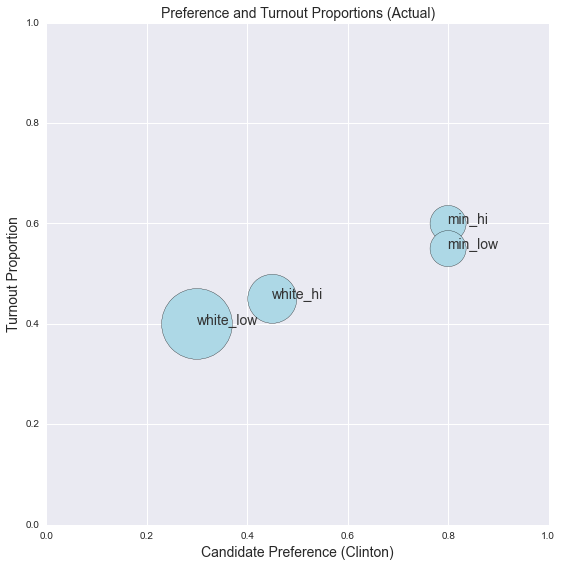

In [21]:
plt.scatter(cand_probs, turn_probs2, s=size_props*10000, c="lightblue")
for k,v in cand_probs.iteritems():
    plt.annotate(k, xy=(cand_probs[k], turn_probs2[k]), fontsize=14, color='#333333')
plt.ylim([0,1])
plt.xlim([0,1])
plt.title("Preference and Turnout Proportions (Actual)", fontsize=14)
plt.xlabel("Candidate Preference (Clinton)", fontsize=14)
plt.ylabel("Turnout Proportion", fontsize=14)
plt.show()

Based on these general trends, voter preference and turnout are quite correlated if we look at the population as a whole.

### Stratifying to Decorrelate

In the population at large, turnout is likely to be correlated with candidate preference. However, among people who have similar experiences and hold similar views, these correlations can be weaker. As mentioned earlier, a key method in polling is to divide the population into **strata**, or groups of people whose behavior is believed to be relatively homogeneous.

In our running example, if we pulled a person from the general population, and saw that they supported Clinton, we would be able to say that they are more likely to be from a minority group because there is stronger support for Clinton from that group. From that conclusion, we could further say that the voter is more likely that the average voter to turn out and vote.

However, if we pulled a person from a particular stratum and saw that they were supporting Clinton, we would already know their minority and income status, so this would give use less new information about their propensity to vote.

In particular, we hope that within these strata, **turnout and vote preference are uncorrelated**.

### Decomposition into Weights and Preferences

Based on the assumption that candidate preference and turnout are uncorrelated within sample, we can decompose total vote share into a **weighted average** of within-stratum candidate preference.

If we divide the population into $K$ strata, we can define the following three sets of quantities:

 * $w_k^{(d)}$: A stratum weight, indicating the proportion of registered voters who fall into this stratum.
 * $w_k^{(t)}$: A turnout weight, indicating the proportion of registered voters in this stratum who wil turn out to vote.
 * $p_k^{(c)}$: Proportion of people in the stratum who prefer the candidate.

Using this notation, we can break down the population vote share as follows:

$$
\mu_v = \sum_{k=1}^K w_k^{(d)} w_k^{(t)} p_k^{(c)},
$$

where, across all strata,
$$
\sum_{k=1}^K w_k^{(d)} w_k^{(t)} = 1.
$$

Intuitively, each stratum's candidate preference $p_k^{(c)}$ will be given a weight proportional to the number of people from that stratum who will ultimately cast votes. The key gain from stratification here is that we can look at each stratum's candidate preference proportion in aggregate, rather than having to know what the turnout status and candidate preference is for each person in the stratum.

### Estimation

We estimate $p_k^{(c)}$ by sampling people from within each stratum -- **if the decorrelated assumption holds**, this will give a good estimate of the vote preference among people in this stratum who will vote.

We set the other quantities using external information:
 * $w_k^{(d)}$ is usually set using census and voter registration data, which are generally very accurate, and
 * $w_k^{(t)}$ is usually set based on historical turnout data, informed in small part by polling response. This is less reliable.
 
Putting this all together, we estimate vote share as follows:

 1. Stratify the population into $K$ homogeneous groups.
 1. Compute stratum weights $w_k^{(d)}$ and turnout weights $w_k^{(t)}$ for each stratum $k$.
 1. Within each stratum, sample $n_k$ people and ask their vote preference.
 1. From each stratum sample, compute: the stratum mean preference
 
     $$\hat c_k = \frac{1}{n_k} \sum_{i=1}^{n_k} c_i$$
     
 1. Combine these components into the final estimate of vote share

    $$
    \hat v = \sum_{k=1}^K w_k^{(d)} w_k^{(t)} \hat c_k
    $$

## Demo of Stratified Estimation

In this demo, we will compute estimates of population vote share $\mu_v$ using the stratification method described above. We will run 1000 simulations, where in each simulation 250 people will be sampled from each of our four strata without replacement (yielding 1000 samples total). We will then combine this with **accurate** stratum and turnout weights.

First, here are the ingredients that go into the weights that will be used:

In [10]:
# Stratum weights
size_props

min_hi       0.13
min_low      0.13
white_hi     0.24
white_low    0.50
dtype: float64

In [11]:
# Turnout weights
turn_probs2

min_hi       0.60
min_low      0.55
white_hi     0.45
white_low    0.40
dtype: float64

From these, we compute the normalized weights (remember, they need to sum to 1).

In [12]:
# Computing normalized weights
weights = (size_props * turn_probs2)
weights = weights / sum(weights)
weights

min_hi       0.170492
min_low      0.156284
white_hi     0.236066
white_low    0.437158
dtype: float64

These weights indicate that we expect, for example, 17% of people who actually cast votes to be from the high-income minority group.

As a reminder, this is the picture of the voting public that these weights represent.

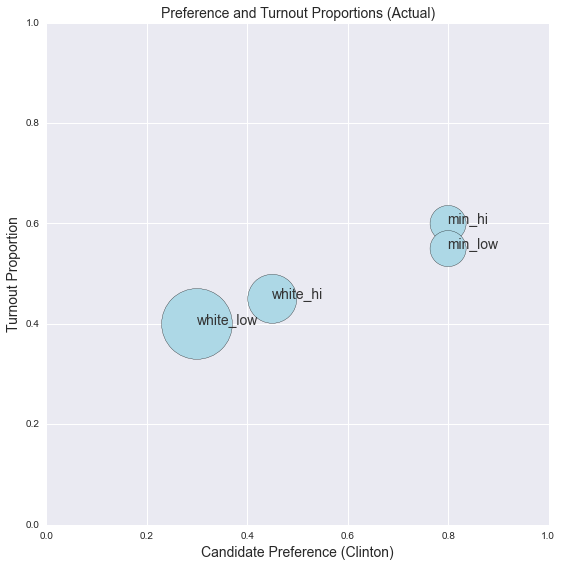

In [13]:
plt.scatter(cand_probs, turn_probs2, s=size_props*10000, c="lightblue")
for k,v in cand_probs.iteritems():
    plt.annotate(k, xy=(cand_probs[k], turn_probs2[k]), fontsize=14, color='#333333')
plt.ylim([0,1])
plt.xlim([0,1])
plt.title("Preference and Turnout Proportions (Actual)", fontsize=14)
plt.xlabel("Candidate Preference (Clinton)", fontsize=14)
plt.ylabel("Turnout Proportion", fontsize=14)
plt.show()

In [14]:
# Run the simulation
M = 1000
strata_idxs = [np.argwhere(sub_label==d).flatten() for d in demos]
true_turnout_v = np.zeros(M)
for i in np.arange(M):
    start = 0
    prefmeans = np.zeros(4)
    for k in np.arange(4):
        selection = np.random.choice(strata_idxs[k], size=int(n / 4), replace=True)
        start += int(size_props.iloc[k]*N)
        # Sample voter preferences
        prefs = clist[selection]
        prefmeans[k] = np.mean(prefs)
    true_turnout_v[i] = np.sum(weights * prefmeans)

The distribution of estimated vote share is summarlized in the following histogram. It is centered at the truth and looks a lot like our idealized vote share histogram in the last section.

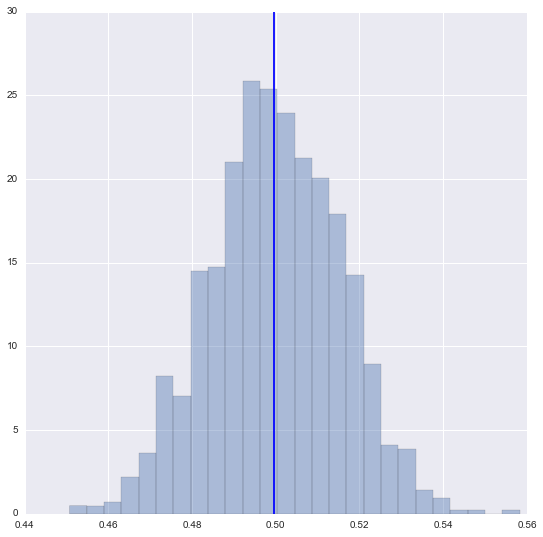

In [15]:
sns.distplot(true_turnout_v, kde=False, norm_hist=True)
plt.axvline(float(np.sum(wlist2)) / np.sum(tlist2))
# plt.axvline(np.percentile(true_turnout_v, 2.5), c='red')
# plt.axvline(np.percentile(true_turnout_v, 97.5), c='red')
plt.show()

## Difficulties with Weighting

The primary difficulty with this stratified approach is that the turnout weights $w_k^{(t)}$ are difficult to estimate well. Because we rely on historical information to compute them, if the dynamics of the current election are very different from previous ones, then the weights can be off by a large margin.

In this demo, we will show how this can happen.

Suppose that our estimated turnout and actual turnout do not match. In particular, suppose that estimated turnout strongly underestimates the turnout from one particular group (here, working class white voters).

In [16]:
# Estimated turnout probabilities, based on historical turnout
pd.DataFrame({'estimated': turn_probs1, 'actual': turn_probs2})

,actual,estimated
min_hi,0.60,0.60
min_low,0.55,0.55
white_hi,0.45,0.45
white_low,0.40,0.30


The estimated turnout probabilities are consistent with this picture of the voting public.

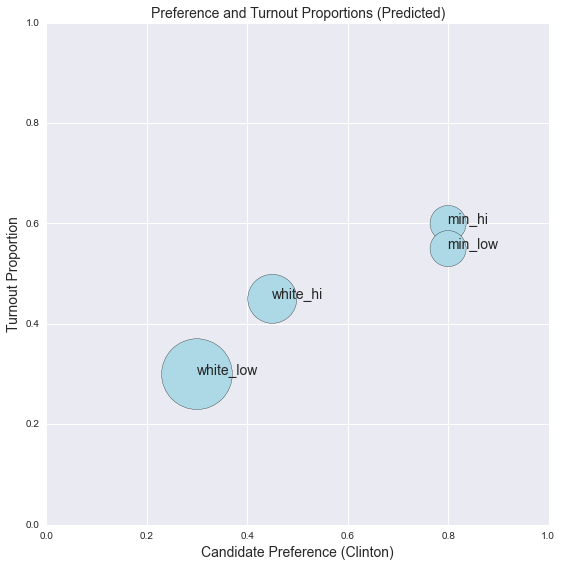

In [17]:
plt.scatter(cand_probs, turn_probs1, s=size_props*10000, c="lightblue")
for k,v in cand_probs.iteritems():
    plt.annotate(k, xy=(cand_probs[k], turn_probs1[k]), fontsize=14)
plt.ylim([0,1])
plt.xlim([0,1])
plt.title("Preference and Turnout Proportions (Predicted)", fontsize=14)
plt.xlabel("Candidate Preference (Clinton)", fontsize=14)
plt.ylabel("Turnout Proportion", fontsize=14)
plt.show()

### Simulation using historical turnout weights

In this section, we rerun the simulation of using the stratified estimation method, but this time we use the weights estimated from historical turnout.

Compare the estimated and actual weights that result:

In [18]:
# Simulation using true weights
est_weights = (size_props * turn_probs1)
est_weights = est_weights / sum(est_weights)
pd.DataFrame({'estimated': est_weights, 'actual': weights})

,actual,estimated
min_hi,0.170492,0.191411
min_low,0.156284,0.175460
white_hi,0.236066,0.265031
white_low,0.437158,0.368098


In [19]:
M = 1000
bad_turnout_v = np.zeros(M)
strata_idxs = [np.argwhere(sub_label==d).flatten() for d in demos]
for i in np.arange(M):
    prefmeans = np.zeros(4)
    for k in np.arange(4):
        # Randomly select people within stratum
        selection = np.random.choice(strata_idxs[k], size=int(n / 4), replace=True)
        # Sample voter preferences
        prefs = clist[selection]
        prefmeans[k] = np.mean(prefs)
    bad_turnout_v[i] = np.sum(est_weights * prefmeans)

The following histogram shows the distribution of polling results using this methodology, compared to the true population vote share (blue) and the vote share that would have resulted if the estimated turnout proportions had been accurate (red). Clearly, if the wrong turnout weights are used, the poll is estimating the wrong quantity, and systematically misses the true vote share.

Truth is green line, estimate using true turnout distributed according to green histogram.
Bad target is blue, estimate using historical turnout distributed according to blue histogram.


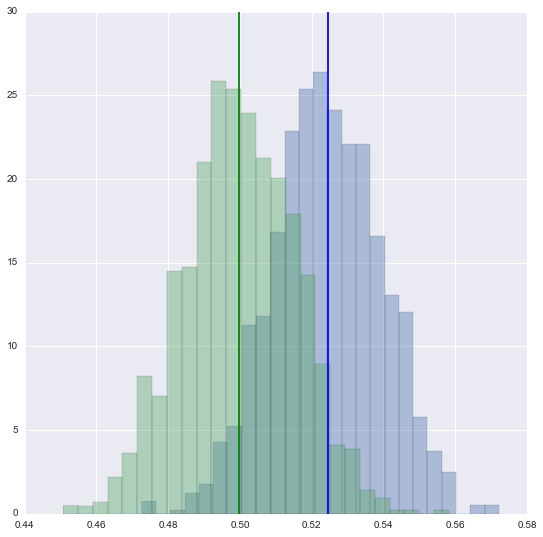

In [20]:
# Plot histogram for estimates using historical turnout numbers
sns.distplot(bad_turnout_v, kde=False, norm_hist=True)
# Plot histogram for estimates using actual turnout numbers
sns.distplot(true_turnout_v, kde=False, norm_hist=True)

plt.axvline(float(np.sum(wlist2)) / np.sum(tlist2), c='green')
plt.axvline(float(np.sum(wlist1)) / np.sum(tlist1))

print "Truth is green line, estimate using true turnout distributed according to green histogram."
print "Bad target is blue, estimate using historical turnout distributed according to blue histogram."

# Conclusion

In very simple terms, this is a major reason that polls failed to paint an accurate picture of Hillary Clinton's vote share in certain states that ended up being pivotal to the election outcome (overall, polls were quite accurate at predicting her national vote share). In predicting the outcomes in these states, there were fundamental assumptions that were wrong and could not be corrected by the collected data. These sorts of errors occur in every election cycle -- it happens that in this case:

 * The error was aligned in a way that the estimates and the actual vote share ended up on different sides of 50%, and
 * The same faulty assumption was used across multiple states, so the predicted vote share in each of these states missed the true vote share in the same direction.

<!-- ## Biases

So far, we have considered polling where we are able to make perfect measurements of each sampled person. In reality, this can break down in several ways; for example, these are some examples of how data can become contaminated:

 * **Non-response**: Many voters are unwilling to talk to a pollster, or are unreachable (e.g., they don't have a landline).
 * **"Shy voter"**: Some voters may be embarrassed to admit their choice.
 * **Turnout reporting**: Many voters do not give a reliable indication of whether they actually will vote
 
If there is a systematic relationship between vote preference and one of these contaminants, then they introduce a **bias** and the polling estimates will be systematically inaccurate, no matter how large the sample is.

This is in contrast to chance variation, which becomes smaller and smaller the more people you poll, according to the square root law. -->